# Empirically Matching Gravitationally Lensed SNe (GLSNe) Lens Galaxies to SL2S

Note: Most of this is copied from the notebook "Empirically Matching OM10 Lens Galaxies to SL2S" by Phil Marshall and Bryce Kalmbach. The first half on generating a model from SL2S is exactly the same. The differences are in the second half of the notebook where we substitude the GLSNe catalog in place of OM10.

_Bryce Kalmbach, August 2018_

We need to be able to assign a stellar mass and size to each of our GLSNe lens galaxies in the catalog provided by Danny Goldstein, so that we can, in turn, associate a suitable `cosmoDC2` galaxy with that object. To do this, we will follow Tom Holoien's "empiriciSN" approach, and model the intrinsic distribution of lens galaxy size, stellar mass, redshift and velocity dispersion with the "extreme deconvolution" algorithm.

SEDs will need to be matched in a separate code since `gcr-catalogs` does not have SEDs in the available as the old CATSIM galaxies did.


## Requirements

You will need to have installed Tom Holoien's [`XDGMM`]() and [`empiriciSN`]() packages, as well as their dependencies. 

> By default, in `empiricSN` all the model fitting is done with the [`AstroML`](http://www.astroml.org/index.html) XDGMM algorithm rather than the [Bovy et al. (2011)](https://github.com/jobovy/extreme-deconvolution) algorithm - for this demo you do not need to have the Bovy et al. algorithm installed to run the code. However, we note that the Bovy et al. algorithm is, in general, significantly (i.e., several times) faster. We recommend you try each method on your dataset when using this class.

In [1]:
import numpy as np
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False
from matplotlib import pyplot as plt
import corner
import urllib
import os
from sklearn.cross_validation import train_test_split
from astroML.plotting import setup_text_plots

import empiriciSN
from MatchingLensGalaxies_utilities import *
%matplotlib inline

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Empirical Strong Lens Data

We'll use the SL2S sample of galaxy-scale lenses to model the properties of GLSNe lenses. The redshifts and velocity dispersions should cover *most* (but not all) of the LSST lensed quasar sample in the GLSNe catalog.

The data is in Table 3 of [Sonnenfeld et al (2013)](https://arxiv.org/abs/1307.4759), and stored as a csv format file in the Twinkles data folder.

In [2]:
def get_sl2s_data():
    filename = '../../data/SonnenfeldEtal2013_Table3.csv'
    ! wc -l $filename

    z = np.array([])
    z_err = np.array([])
    v_disp = np.array([])
    v_disp_err = np.array([])
    r_eff = np.array([])
    r_eff_err = np.array([])
    log_m = np.array([])
    log_m_err = np.array([])
    
    infile = open(filename, 'r')
    inlines = infile.readlines()
    
    for line1 in inlines:
        if line1[0] == '#': continue
        line = line1.split(',')
        
        #Params
        z = np.append(z, float(line[1]))
        v_disp = np.append(v_disp, float(line[2]))
        r_eff = np.append(r_eff, float(line[3]))
        log_m = np.append(log_m, float(line[4]))
        
        #Errors
        z_err = np.append(z_err, float(line[5]))
        v_disp_err = np.append(v_disp_err, float(line[6]))
        r_eff_err = np.append(r_eff_err, float(line[7]))
        log_m_err = np.append(log_m_err, float(line[8]))
    
    #Build final arrays
    X = np.vstack([z, v_disp, r_eff, log_m]).T
    Xerr = np.zeros(X.shape + X.shape[-1:])
    diag = np.arange(X.shape[-1])
    
    Xerr[:, diag, diag] = np.vstack([z_err**2, v_disp_err**2,
                                    r_eff_err**2, log_m_err**2]).T
    
    return X, Xerr

# Here's what we did to get the csv file:
# ! echo "ID, zlens, vdisp, Reff, Mstar, zlens_err, vdisp_err, Reff_err, Mstar_err" > SonnenfeldEtal2013_Table3.csv  
# ! cat gammaptable.tex | sed s%'&'%%g | sed s%'\$'%%g | sed s%'\\'%%g | sed s%'pm'%'  '%g | sed s%'disky'%%g | awk '{print $1", "$2", "$5", "$3", "$7", 0.001, "$6", 0.01, "$8}' >> SonnenfeldEtal2013_Table3.csv

## Component Test

We could fit our lens galaxy dataset directly, but one problem is that we don't know the optimal number of components (Gaussians) to use in the fit. Knowing the optimal number of components to fit allows us to obtain a good fit in the smallest amount of time without overfitting the data.

### BIC
One way to determine the optimal number of Gaussian components to use in the model is by fitting the model with different numbers of components and calculating the Bayesian information criterion (BIC) for each model. The BIC incorporates the number of components in the model, the sample size, and the likelihood of the data under the model, and the model with the lowest score is the optimal model to use.

We can test for the model with the lowest BIC score for a given dataset using the `component_test` function, which will compute the BIC for a given dataset and range of n_components and return an array containing all the BIC scores as well as the optimal number of components and corresponding BIC value. The code below will read in all the SN and host parameters we want to use from our data files (using the `get_data` function) and use these data to test the performance of the model with n_components ranging from 1 to 8. (Larger numbers of components tend to run into errors occurring because too few observations map to a given Gaussian component. With a bigger dataset, this range could be increased.)

<Note that due to the multiple fits and the large dataset, the BIC test will likely take a while to run, depending on your system.>

In [3]:
# Instantiate an empiriciSN worker object:
empiricist = empiriciSN.Empiricist()

In [4]:
# Define the range of component numbers and read in the dataset:
component_range = np.array([1,2,3,4,5,6,7,8])
X, Xerr = get_sl2s_data()

26 ../../data/SonnenfeldEtal2013_Table3.csv


In [5]:
%%capture --no-stdout
# Loop over component numbers, fitting XDGMM model and computing the BIC. 

bics, optimal_n_comp, lowest_bic = empiricist.component_test(X, Xerr, component_range)

N = 1 , BIC = 404.677168861
N = 2 , BIC = 410.426768575
N = 3 , BIC = 442.266672909
N = 4 , BIC = 453.721342968
N = 5 , BIC = 482.676598861
N = 6 , BIC = 510.151167274
N = 7 , BIC = 516.102288146
N = 8 , BIC = 549.019699858


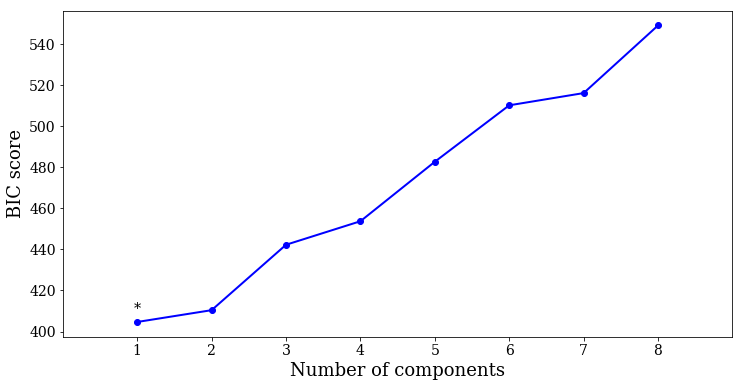

In [6]:
plot_bic(component_range, bics, optimal_n_comp)

> Based on the results of the above test, the model with 1 component has the lowest BIC score and is the optimal choice.


## Fitting a Model

Once we know how many components to use in the model, we can fit a model using that number of components using the `fit_model` function. Before fitting for this demo, we are going to split our lens galaxy dataset 65-35, with the larger subsample being used to fit the model and the smaller subsample providing a test sample that we can use to predict stellar masses and compare with our predicted sample.

In [7]:
%%capture --no-stdout
# Split the dataset 65/35:
X_train, X_test, Xerr_train, Xerr_test = \
    train_test_split(X, Xerr, test_size=0.35, random_state=17)

# Fit the model:
empiricist.fit_model(X_train, Xerr_train, filename = 'demo_model.fit', n_components=1)
#empiricist.read_model('demo_model.fit')

Note how the `fit_model` function also saves the fit to a file for later re-use. If a model has already been fit, it can be read into an existing `Empiricist` worker, or a new `Empiricist` can be instantiated using the model, like this:

In [8]:
alternative = empiriciSN.Empiricist(model_file='demo_model.fit')

# Print the weights array for each object---they should be the same...
print(empiricist.XDGMM.weights)
print(alternative.XDGMM.weights)

[ 1.]
[ 1.]


## Predicting stellar masses of lens galaxies

Our goal in this notebook is to predict the stellar masses of OM10 lens galaxies. Here we use the XDGMM model we just fit on the test data we separated off from the full dataset. We will use the model to predict stellar masses of lens galaxies based upon their redshift, velocity dispersion and radial size.

<The "test" sample generated above gives us a set of 482 host properties that we can use to fit supernovae, and a set of supernova properties to compare with our model fits.>

First, we adapt the "get_logR" function from empiriciSN to "get_log_m" changing the references and restrictions of that method (it only allows certain columns due to structure of SN dataset it uses) to suit our strong lensing dataset.

In [9]:
#Write new conditioning function
def get_log_m(cond_indices, m_index, X, model_file, Xerr=None):
    
    """
        Uses a subset of parameters in the given data to condition the
        model and return a sample value for log(M/M_sun).

        Parameters
        ----------
        cond_indices: array_like
            Array of indices indicating which parameters to use to
            condition the model. 
        m_index: int
            Index of log(M/M_sun) in the list of parameters that were used
            to fit the model.
        X: array_like, shape = (n < n_features,)
            Input data.
        Xerr: array_like, shape = (X.shape,) (optional)
            Error on input data. If none, no error used to condition.

        Returns
        -------
        log_m: float
            Sample value of log(M/M_sun) taken from the conditioned model.

        Notes
        -----
        The fit_params array specifies a list of indices to use to
        condition the model. The model will be conditioned and then
        a mass will be drawn from the conditioned model.

        This is so that the mass can be used to find cosmoDC2 galaxies
        to act as hosts for GLSNe systems.

        This does not make assumptions about what parameters are being
        used in the model, but does assume that the model has been
        fit already.
    """

    if m_index in cond_indices:
        raise ValueError("Cannot condition model on log(M/M_sun).")

    cond_data = np.array([])
    if Xerr is not None: cond_err = np.array([])
    m_cond_idx = m_index
    n_features = empiricist.XDGMM.mu.shape[1]
    j = 0

    for i in range(n_features):
        if i in cond_indices:
            cond_data = np.append(cond_data,X[j])
            if Xerr is not None: cond_err = np.append(cond_err, Xerr[j])
            j += 1
            if i < m_index: m_cond_idx -= 1
        else:
            cond_data = np.append(cond_data,np.nan)
            if Xerr is not None: cond_err = np.append(cond_err, 0.0)

    if Xerr is not None:
        cond_XDGMM = empiricist.XDGMM.condition(cond_data, cond_err)
    else: cond_XDGMM = empiricist.XDGMM.condition(cond_data)

    sample = cond_XDGMM.sample()
    log_m = sample[0][m_cond_idx]
    return log_m

With that ready to go, we now use it to get estimates on the stellar mass of our test data from the model we have trained above.

In [10]:
%%capture --no-stdout
# Get actual masses from dataset, for comparison:
log_m_test = X_test[:,3]
r_test = X_test[:,2]

# Predict a mass for each galaxy:
np.random.seed(0)
cond_indices = np.array([0,1])
sample_log_m = np.array([])
sample_r = np.array([])

model_file='demo_model.fit'

for x, xerr in zip(X_test, Xerr_test):
    log_m = get_log_m(cond_indices, 3, x[cond_indices], model_file)#, Xerr=xerr)
    sample_log_m = np.append(sample_log_m,log_m)
    print(x[3], log_m)
    
for x, xerr in zip(X_test, Xerr_test):
    r_cond = get_log_m(cond_indices, 2, x[cond_indices], model_file)#, Xerr=xerr)
    sample_r = np.append(sample_r,r_cond)
    print(x[2], r_cond)

11.76 11.331095751
11.45 11.4383623875
11.6 11.472890811
11.28 11.1648297715
11.81 11.2007569882
11.14 11.4886673289
11.26 11.4436672157
11.51 12.2439183667
11.53 11.7600296547
7.86 6.25885282711
8.92 8.05264143642
4.35 13.7363710186
3.04 3.37140361718
8.59 4.61904829769
1.35 0.586960021396
3.86 7.39634635567
3.93 7.89501023704
4.27 12.8430002306


Now we have a set of test masses in units of log(M/M_sun) and a set of masses sampled from the model. These should have the same distribution when plotted.

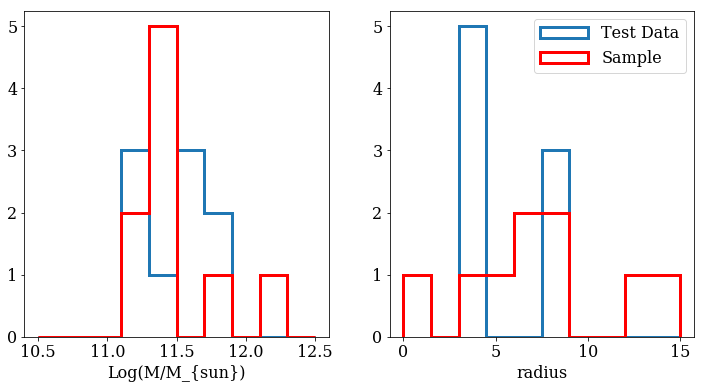

In [11]:
fig = plt.figure(figsize=(12,6))

fig.add_subplot(121)
plt.hist(log_m_test, 10, range=(10.5, 12.5), histtype='step', lw=3)
plt.hist(sample_log_m, 10, range=(10.5, 12.5), color ='r', histtype='step', lw=3)
plt.xlabel('Log(M/M_{sun})')

fig.add_subplot(122)
plt.hist(r_test, 10, range=(0, 15), histtype='step', lw=3)
plt.hist(sample_r, 10, range=(0, 15), color ='r', histtype='step', lw=3)
plt.xlabel('radius')
plt.legend(('Test Data', 'Sample'))
plt.show()

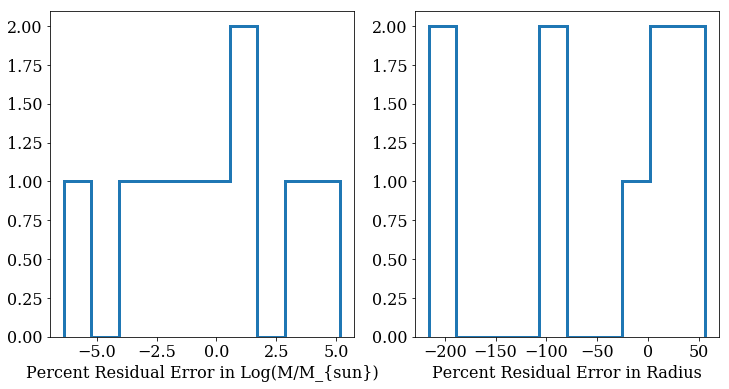

In [12]:
fig = plt.figure(figsize=(12,6))

fig.add_subplot(121)
plt.hist(100*(log_m_test-sample_log_m)/log_m_test, 10, histtype='step', lw=3)
plt.xlabel('Percent Residual Error in Log(M/M_{sun})')

fig.add_subplot(122)
plt.hist(100*(r_test-sample_r)/r_test, 10, histtype='step', lw=3)
plt.xlabel('Percent Residual Error in Radius')

It seems that while we can predict the stellar masses to a reasonable degree the estimates for Radius are very poor and we should get those values from cosmoDC2 while matching galaxies on just stellar mass, redshift and ellipticity.

We want to make sure that the model gives reasonable values when generating masses, redshift and velocity dispersions. Therefore, we will sample the GMM and plot against the test data.

In [13]:
%%capture --no-stdout
empiricist.fit_model(X_train, Xerr_train, filename = 'demo_model.fit', n_components=1)
test_sample = empiricist.XDGMM.sample(size=10000)

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs ['ms', 'markersize'] which are all aliases for 'markersize'.  Kept value from 'markersize'
  seen=seen, canon=canonical, used=seen[-1]))


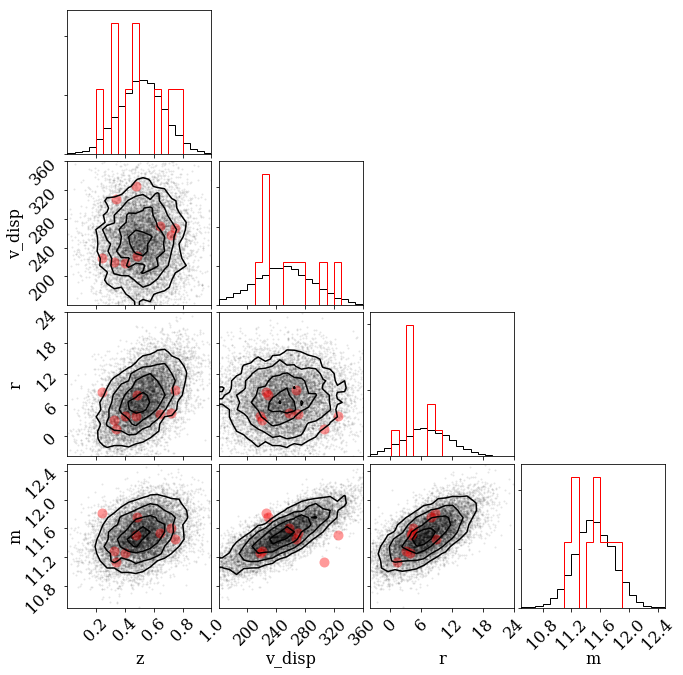

In [14]:
setup_text_plots(fontsize=16, usetex=False)
mpl.rcParams['text.usetex'] = False

figure = corner.corner(test_sample[:,:], labels=['z', 'v_disp', 'r', 'm'], 
                       range = [(0.0, 1.0), (160, 360), (-4, 24), (10.5, 12.5)],
              hist_kwargs = {'normed': True}, no_fill_contours=True, 
              plot_density=False)

corner.corner(X_test[:, :], labels=['z', 'v_disp', 'r', 'm'], color='red', 
              range = [(0.0, 1.0), (160, 360), (-4, 24), (10.5, 12.5)],
              hist_kwargs = {'normed':True}, plot_contours=False, 
              plot_density=False, plot_datapoints=True, 
              data_kwargs={'marker':'o', 'alpha':0.4, 'markersize':10}, 
              fig=figure)
plt.show()

Here we try fitting our model with 2 components in the GMM.

In [15]:
%%capture --no-stdout
empiricist.fit_model(X_train, Xerr_train, filename = 'demo_model.fit', n_components=2)

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs ['ms', 'markersize'] which are all aliases for 'markersize'.  Kept value from 'markersize'
  seen=seen, canon=canonical, used=seen[-1]))


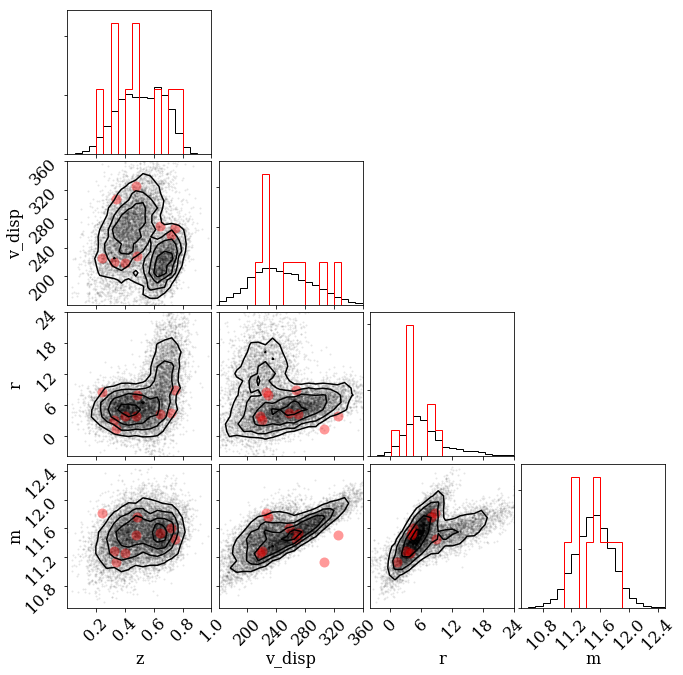

In [16]:
test_sample = empiricist.XDGMM.sample(size=10000)
setup_text_plots(fontsize=16, usetex=False)
mpl.rcParams['text.usetex'] = False

figure = corner.corner(test_sample[:,:], labels=['z', 'v_disp', 'r', 'm'], 
                       range = [(0.0, 1.0), (160, 360), (-4, 24), (10.5, 12.5)],
              hist_kwargs = {'normed': True}, no_fill_contours=True, 
              plot_density=False)

corner.corner(X_test[:, :], labels=['z', 'v_disp', 'r', 'm'], color='red', 
              range = [(0.0, 1.0), (160, 360), (-4, 24), (10.5, 12.5)],
              hist_kwargs = {'normed':True}, plot_contours=False, 
              plot_density=False, plot_datapoints=True, 
              data_kwargs={'marker':'o', 'alpha':0.4, 'markersize':10}, 
              fig=figure)
plt.show()

And here we use 3 components.

In [17]:
%%capture --no-stdout
empiricist.fit_model(X_train, Xerr_train, filename = 'demo_model.fit', n_components=3)

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs ['ms', 'markersize'] which are all aliases for 'markersize'.  Kept value from 'markersize'
  seen=seen, canon=canonical, used=seen[-1]))


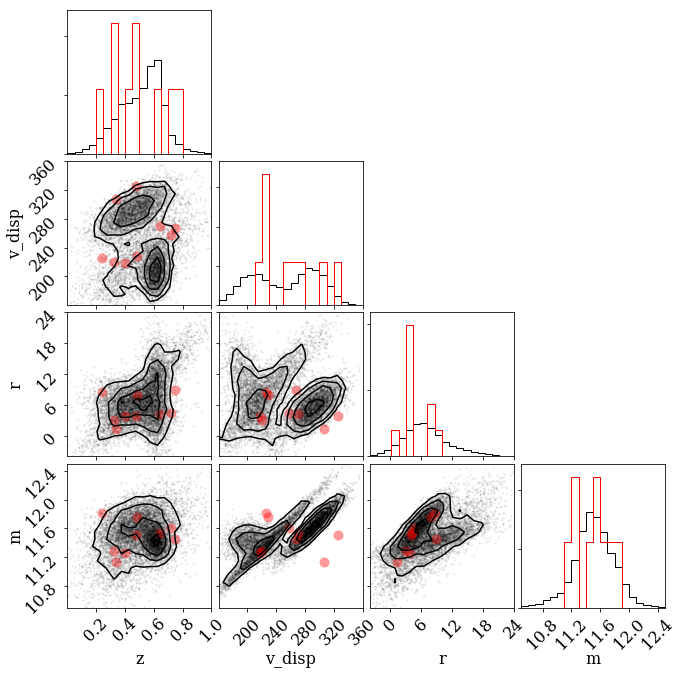

In [18]:
test_sample = empiricist.XDGMM.sample(size=10000)
setup_text_plots(fontsize=16, usetex=False)
mpl.rcParams['text.usetex'] = False

figure = corner.corner(test_sample[:,:], labels=['z', 'v_disp', 'r', 'm'], 
                       range = [(0.0, 1.0), (160, 360), (-4, 24), (10.5, 12.5)],
              hist_kwargs = {'normed': True}, no_fill_contours=True, 
              plot_density=False)

corner.corner(X_test[:, :], labels=['z', 'v_disp', 'r', 'm'], color='red', 
              range = [(0.0, 1.0), (160, 360), (-4, 24), (10.5, 12.5)],
              hist_kwargs = {'normed':True}, plot_contours=False, 
              plot_density=False, plot_datapoints=True, 
              data_kwargs={'marker':'o', 'alpha':0.4, 'markersize':10}, 
              fig=figure)
plt.show()

### Estimating Stellar Masses for GLSNe systems

We have decided to move forward with the 1-parameter GMM model and will now use the available data in GLSNe sytems to find a stellar mass for GLSNe systems based upon redshift and velocity dispersion. Since our attempts to predict radius seem to be inaccurate we will get radius estimate from cosmoDC2 galaxies as well and thus only will be predicting stellar masses for GLSNe lenses here.

In [19]:
# First load in GLSNe lenses we are using in Twinkles

import pandas as pd
df = pd.read_csv('../../data/v1_sne_cat.csv')
system_rows = []
unique_systems = []
for sys_num in np.unique(df['twinkles_sysno']):
    system_rows.append(np.where(df['twinkles_sysno'] == sys_num)[0])
    unique_systems.append(system_rows[-1][0])

In [20]:
unique_df = df.iloc[unique_systems]

In [99]:
# Predict a mass for each galaxy:
np.random.seed(0)
cond_indices = np.array([0,1])
twinkles_log_m = np.array([])
twinkles_reff = np.array([])

model_file='demo_model.fit'
empiricist.fit_model(X_train, Xerr_train, filename = 'demo_model.fit', n_components=1)
twinkles_data = np.array([unique_df['zl'], unique_df['sigma']]).T

for x in twinkles_data:
    log_m = get_log_m(cond_indices, 3, x[cond_indices], model_file)
    twinkles_log_m = np.append(twinkles_log_m,log_m)

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.

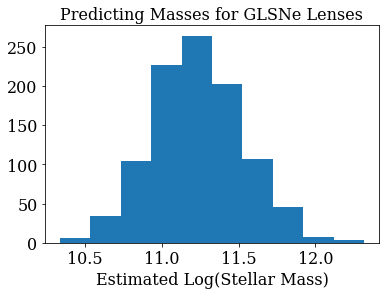

In [100]:
mpl.rcParams['text.usetex'] = False
plt.hist(twinkles_log_m)
plt.xlabel('Estimated Log(Stellar Mass)')
plt.title('Predicting Masses for GLSNe Lenses')

Now we connect to the cosmoDC2 database and use redshift, stellar_mass and ellipticity of our GLSNe galaxies to find associated radial sizes for our galaxies. The query looks for any galaxies within 10% in dex of redshift and 10% of stellar mass and ellipticity. For our lens galaxies we don't want disks. However, limiting ourselves in cosmoDC2 to only galaxies with `stellar_mass_disk` == 0.0 was too restrictive and we instead take the bulge properties for galaxies where the stellar mass of the bulge is over 99% of the total stellar mass. If no matches are found then it will skip on to the next system and we will leave that GLSNe system out of the catalog available to the sprinkler.

In [23]:
import GCRCatalogs
import pandas as pd
from GCR import GCRQuery

In [63]:
catalog = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image')

In [120]:
%%time
gcr_glsn_match = []
err = 0
np.random.seed(10)
i = 0

z_cat_min = np.power(10, np.log10(np.min(unique_df['zl'])) - .1)
z_cat_max = np.power(10, np.log10(np.max(unique_df['zl'])) + .1)

stellar_mass_cat_min = np.min(np.power(10, twinkles_log_m))*0.9
stellar_mass_cat_max = np.max(np.power(10, twinkles_log_m))*1.1

data = catalog.get_quantities(['redshift_true', 'stellar_mass', 'ellipticity_true', 'size_true', 'size_minor_true', 
                               'stellar_mass_bulge', 'stellar_mass_disk', 'size_bulge_true', 'size_minor_bulge_true', 'galaxy_id'],
                              filters=['stellar_mass > %f' % stellar_mass_cat_min, 'stellar_mass < %f' % stellar_mass_cat_max,
                                       'redshift_true > %f' % z_cat_min, 'redshift_true < %f' % z_cat_max,
                                       'stellar_mass_bulge/stellar_mass > 0.99'])

#### Important Note
# Twinkles issue #310 (https://github.com/LSSTDESC/Twinkles/issues/310) says OM10 defines ellipticity as 1 - b/a but
# gcr_catalogs defines ellipticity as (1-b/a)/(1+b/a) (https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/SCHEMA.md)

data['glsn_ellipticity'] = (1-(data['size_minor_bulge_true']/data['size_bulge_true']))

data_df = pd.DataFrame(data)
print(data_df.head(10))

row_num = -1
keep_rows = []

for zsrc, m_star, ellip in zip(unique_df['zl'], np.power(10, twinkles_log_m), unique_df['e']):

    row_num += 1
    #print(zsrc, m_star, ellip)
    if i % 1000 == 0:
        print(i)
    i += 1

    z_min, z_max = np.power(10, np.log10(zsrc) - .1), np.power(10, np.log10(zsrc) + .1)
    m_star_min, m_star_max = m_star*.9, m_star*1.1
    ellip_min, ellip_max = ellip*.9, ellip*1.1
    
    data_subset = data_df.query('redshift_true > %f and redshift_true < %f and stellar_mass > %f and stellar_mass < %f and glsn_ellipticity > %f and glsn_ellipticity < %f' %
                                (z_min, z_max, m_star_min, m_star_max, ellip_min, ellip_max))
    
    #data = catalog.get_quantities(['redshift_true', 'stellar_mass', 'ellipticity_true'])
    #data_subset = (query).filter(data)
    #print(data_subset)
    num_matches = len(data_subset['redshift_true'])
        
    if num_matches == 0:
        err += 1
        continue
    elif num_matches == 1:
        gcr_data = [data_subset['redshift_true'].values[0], 
                    data_subset['stellar_mass_bulge'].values[0],
                    data_subset['glsn_ellipticity'].values[0],
                    data_subset['size_bulge_true'].values[0],
                    data_subset['size_minor_bulge_true'].values[0],
                    data_subset['galaxy_id'].values[0]]
        gcr_glsn_match.append(gcr_data)
        keep_rows.append(row_num)
    elif num_matches > 1:
        use_idx = np.random.choice(num_matches)
        gcr_data = [data_subset['redshift_true'].values[use_idx], 
                    data_subset['stellar_mass_bulge'].values[use_idx],
                    data_subset['glsn_ellipticity'].values[use_idx],
                    data_subset['size_bulge_true'].values[use_idx],
                    data_subset['size_minor_bulge_true'].values[use_idx],
                    data_subset['galaxy_id'].values[use_idx]]
        gcr_glsn_match.append(gcr_data)
        keep_rows.append(row_num)
        
print("Total Match Failures: ", err, " Percentage Match Failures: ", np.float(err)/len(twinkles_log_m))

   ellipticity_true  galaxy_id  glsn_ellipticity  redshift_true  \
0          0.308243        418          0.452288       0.047330   
1          0.010706        434          0.021241       0.047615   
2          0.034487        574          0.064486       0.047066   
3          0.007880        759          0.015574       0.044245   
4          0.202388        813          0.332250       0.047565   
5          0.064616        841          0.120953       0.047334   
6          0.205524       1057          0.331149       0.045305   
7          0.167110       1166          0.272906       0.047070   
8          0.042245       1314          0.080729       0.047262   
9          0.058847       1405          0.067833       0.046156   

   size_bulge_true  size_minor_bulge_true  size_minor_true  size_true  \
0         4.942575               2.707107         2.667601   5.044940   
1         3.016575               2.952500         2.958531   3.022562   
2         6.691544               6.260032  

In [121]:
gcr_z = []
gcr_m_star = []
gcr_r_eff = []
gcr_gal_id = []
for row in gcr_glsn_match:
    gcr_z.append(row[0])
    gcr_m_star.append(row[1])
    gcr_r_eff.append(np.sqrt(row[3]*row[4]))
    gcr_gal_id.append(row[5])

(array([  33.,   88.,  181.,  147.,  143.,   89.,   96.,   77.,   48.,
          26.,   18.,    9.]),
 array([ 0.05040373,  0.11410343,  0.17780313,  0.24150283,  0.30520253,
         0.36890223,  0.43260193,  0.49630163,  0.56000133,  0.62370104,
         0.68740074,  0.75110044,  0.81480014]),
 <a list of 12 Patch objects>)

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


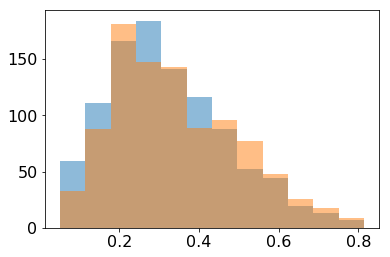

In [122]:
#Let's take a look at a couple results
mpl.rcParams['text.usetex'] = False
n, bins, p = plt.hist(unique_df['zl'], alpha=0.5, bins=12)
plt.hist(gcr_z, alpha=0.5, bins=bins)

(array([   4.,   20.,   59.,  129.,  211.,  210.,  163.,  112.,   39.,
          16.,    2.,    0.]),
 array([ 10.33691565,  10.50195304,  10.66699044,  10.83202784,
         10.99706523,  11.16210263,  11.32714003,  11.49217742,
         11.65721482,  11.82225222,  11.98728961,  12.15232701,  12.31736441]),
 <a list of 12 Patch objects>)

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


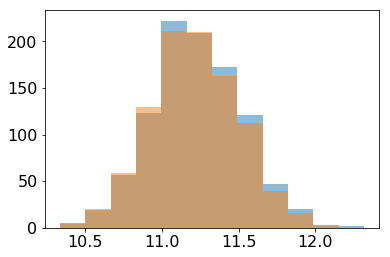

In [123]:
#Let's take a look at a couple results
n, bins, p = plt.hist(twinkles_log_m, alpha=0.5, bins=12)#, range=(0,100))
plt.hist(np.log10(gcr_m_star), alpha=0.5, bins=bins)

We are able to match over 96% of the systems and seems to do well overall with the exception of low redshift lens galaxies. Just for comparison we also run this with the 2 component model below to see if this improves matching at low Z.

In [ ]:
# 13 December 2018
# Scott Daniel is commenting this cell out because it is not meant to
# be run in production (note the comment below indicating that)
# the 1-parameter model run above is preferred

# Predict a mass for each galaxy:
"""
np.random.seed(0)
cond_indices = np.array([0,1])
twinkles_log_m = np.array([])
twinkles_reff = np.array([])

model_file='demo_model.fit'
empiricist.fit_model(X_train, Xerr_train, filename = 'demo_model.fit', n_components=2)
twinkles_data = np.array([unique_df['zl'], unique_df['sigma']]).T

for x in twinkles_data:
    log_m = get_log_m(cond_indices, 3, x[cond_indices], model_file)
    twinkles_log_m = np.append(twinkles_log_m,log_m)
"""

In [ ]:
# 13 December 2018
# Scott Daniel is commenting this cell out because it is not meant to
# be run in production (note the comment below indicating that)
# the 1-parameter model run above is preferred

"""
%%time
gcr_glsn_match = []
err = 0
np.random.seed(10)
i = 0

z_cat_min = np.power(10, np.log10(np.min(unique_df['zl'])) - .1)
z_cat_max = np.power(10, np.log10(np.max(unique_df['zl'])) + .1)

stellar_mass_cat_min = np.min(np.power(10, twinkles_log_m))*0.9
stellar_mass_cat_max = np.max(np.power(10, twinkles_log_m))*1.1

data = catalog.get_quantities(['redshift_true', 'stellar_mass', 'ellipticity_true', 'size_true', 'size_minor_true', 
                               'stellar_mass_bulge', 'stellar_mass_disk', 'size_bulge_true', 'size_minor_bulge_true'],
                              filters=['stellar_mass > %f' % stellar_mass_cat_min, 'stellar_mass < %f' % stellar_mass_cat_max,
                                       'redshift_true > %f' % z_cat_min, 'redshift_true < %f' % z_cat_max,
                                       'stellar_mass_bulge/stellar_mass > 0.95'])

#### Important Note
# Twinkles issue #310 (https://github.com/LSSTDESC/Twinkles/issues/310) says OM10 defines ellipticity as 1 - b/a but
# gcr_catalogs defines ellipticity as (1-b/a)/(1+b/a) (https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/SCHEMA.md)

data['glsn_ellipticity'] = (1-(data['size_minor_bulge_true']/data['size_bulge_true']))

data_df = pd.DataFrame(data)
print(data_df.head(10))

for zsrc, m_star, ellip in zip(unique_df['zl'], np.power(10, twinkles_log_m), unique_df['e']):

    #print(zsrc, m_star, ellip)
    if i % 1000 == 0:
        print(i)
    i += 1

    z_min, z_max = np.power(10, np.log10(zsrc) - .1), np.power(10, np.log10(zsrc) + .1)
    m_star_min, m_star_max = m_star*.9, m_star*1.1
    ellip_min, ellip_max = ellip*.9, ellip*1.1
    
    data_subset = data_df.query('redshift_true > %f and redshift_true < %f and stellar_mass > %f and stellar_mass < %f and glsn_ellipticity > %f and glsn_ellipticity < %f' %
                                (z_min, z_max, m_star_min, m_star_max, ellip_min, ellip_max))
    
    #data = catalog.get_quantities(['redshift_true', 'stellar_mass', 'ellipticity_true'])
    #data_subset = (query).filter(data)
    #print(data_subset)
    num_matches = len(data_subset['redshift_true'])
        
    if num_matches == 0:
        err += 1
        continue
    elif num_matches == 1:
        gcr_data = [data_subset['redshift_true'].values[0], 
                    data_subset['stellar_mass_bulge'].values[0],
                    data_subset['glsn_ellipticity'].values[0],
                    data_subset['size_bulge_true'].values[0],
                    data_subset['size_minor_bulge_true'].values[0]]
        gcr_glsn_match.append(gcr_data)
    elif num_matches > 1:
        use_idx = np.random.choice(num_matches)
        gcr_data = [data_subset['redshift_true'].values[use_idx], 
                    data_subset['stellar_mass_bulge'].values[use_idx],
                    data_subset['glsn_ellipticity'].values[use_idx],
                    data_subset['size_bulge_true'].values[use_idx],
                    data_subset['size_minor_bulge_true'].values[use_idx],
                    data_subset['galaxy_id'].values[use_idx]]
        gcr_glsn_match.append(gcr_data)
        
print("Total Match Failures: ", err, " Percentage Match Failures: ", np.float(err)/len(twinkles_log_m))
"""

In [ ]:
# 13 December 2018
# Scott Daniel is commenting this cell out because it is not meant to
# be run in production (note the comment below indicating that)
# the 1-parameter model run above is preferred

"""
gcr_z = []
gcr_m_star = []
gcr_r_eff = []
gcr_gal_id = []
for row in gcr_glsn_match:
    gcr_z.append(row[0])
    gcr_m_star.append(row[1])
    gcr_r_eff.append(np.sqrt(row[3]*row[4]))
    gcr_gal_id.append(row[5])
"""

In [ ]:
# 13 December 2018
# Scott Daniel is commenting this cell out because it is not meant to
# be run in production (note the comment below indicating that)
# the 1-parameter model run above is preferred

"""
n, bins, p = plt.hist(unique_df['zl'], alpha=0.5, bins=12)
plt.hist(gcr_z, alpha=0.5, bins=bins)
"""

In [ ]:
# 13 December 2018
# Scott Daniel is commenting this cell out because it is not meant to
# be run in production (note the comment below indicating that)
# the 1-parameter model run above is preferred

#Let's take a look at a couple results
"""
n, bins, p = plt.hist(twinkles_log_m, alpha=0.5, bins=15)#, range=(0,100))
plt.hist(np.log10(gcr_m_star), alpha=0.5, bins=bins)
"""

Adding the extra component to the model doesn't seem to make much of a difference in this catalog so we move forward with the 1-component model favored by the BIC comparison above.

## Matching to SEDs using `sims_GCRCatSimInterface`

The other thing we want to add into the lensing catalogs are SEDs for the lens galaxies. Here we get the top hat filters out of cosmoDC2 and use the code in `sims_GCRCatSimInterface` to match these values to a CATSIM SED file in the same way the galaxies are matched for Instance Catalog production in DC2. We also use the code to calculate the magnitude normalization for PhoSim.

In [ ]:
from desc.sims.GCRCatSimInterface import sed_from_galacticus_mags

In [ ]:
H0 = catalog.cosmology.H0.value
Om0 = catalog.cosmology.Om0

In [ ]:
sed_label = []
sed_min_wave = []
sed_wave_width = []
for quant_label in sorted(catalog.list_all_quantities()):
    if (quant_label.startswith('sed') and quant_label.endswith('bulge')):
        sed_label.append(quant_label)
        label_split = quant_label.split('_')
        sed_min_wave.append(int(label_split[1])/10)
        sed_wave_width.append(int(label_split[2])/10)
bin_order = np.argsort(sed_min_wave)
sed_label = np.array(sed_label)[bin_order]
sed_min_wave = np.array(sed_min_wave)[bin_order]
sed_wave_width = np.array(sed_wave_width)[bin_order]

Check to see that our bins are now in order when we call them.

In [108]:
for i in zip(sed_label, sed_min_wave, sed_wave_width):
    print(i)

('sed_1000_246_bulge', 100.0, 24.600000000000001)
('sed_1246_306_bulge', 124.59999999999999, 30.600000000000001)
('sed_1552_381_bulge', 155.19999999999999, 38.100000000000001)
('sed_1933_474_bulge', 193.30000000000001, 47.399999999999999)
('sed_2407_591_bulge', 240.69999999999999, 59.100000000000001)
('sed_2998_186_bulge', 299.80000000000001, 18.600000000000001)
('sed_3184_197_bulge', 318.39999999999998, 19.699999999999999)
('sed_3381_209_bulge', 338.10000000000002, 20.899999999999999)
('sed_3590_222_bulge', 359.0, 22.199999999999999)
('sed_3812_236_bulge', 381.19999999999999, 23.600000000000001)
('sed_4048_251_bulge', 404.80000000000001, 25.100000000000001)
('sed_4299_266_bulge', 429.89999999999998, 26.600000000000001)
('sed_4565_283_bulge', 456.5, 28.300000000000001)
('sed_4848_300_bulge', 484.80000000000001, 30.0)
('sed_5148_319_bulge', 514.79999999999995, 31.899999999999999)
('sed_5467_339_bulge', 546.70000000000005, 33.899999999999999)
('sed_5806_360_bulge', 580.60000000000002, 36

In [124]:
del(data)
del(data_df)

In [125]:
columns = ['galaxy_id', 'redshift_true']
for sed_bin in sed_label:
    columns.append(sed_bin)
data = catalog.get_quantities(columns,
                              filters=['stellar_mass > %f' % stellar_mass_cat_min, 'stellar_mass < %f' % stellar_mass_cat_max,
                                       'redshift_true > %f' % z_cat_min, 'redshift_true < %f' % z_cat_max,
                                       'stellar_mass_bulge/stellar_mass > 0.99'])
data_df = pd.DataFrame(data)

In [126]:
%%time
sed_name_list = []
magNorm_list = []
i = 0
for gal_id, gal_z in zip(gcr_gal_id, gcr_z):
    
    if i % 1000 == 0:
        print(i)
    i+=1
    
    data_subset = data_df.query(str('galaxy_id == %i' % gal_id + ' and ' + 'redshift_true == {}'.format(gal_z))) ## Galaxy Ids are not unique in cosmoDC2_v0.1
    mag_array = []
    for sed_bin in sed_label:
        mag_array.append(-2.5*np.log10(data_subset[sed_bin].values[0]))
    mag_array = np.array(mag_array)
    sed_name, magNorm = sed_from_galacticus_mags(np.array([mag_array]).T, np.array([gal_z]), H0, Om0, sed_min_wave, sed_wave_width)
    sed_name_list.append(sed_name)
    magNorm_list.append(magNorm)
print(len(sed_name_list), len(keep_rows))

0
966 966
CPU times: user 15.4 s, sys: 102 ms, total: 15.5 s
Wall time: 12.5 s


In [127]:
sed_name_array = np.array(sed_name_list)
magNorm_array = np.array(magNorm_list)

## Adding new info to Twinkles GLSNe catalog

We will take all the columns currently in the Twinkles GLSNe catalog and add in our new reff values, SED filenames and SED magnitude normalizations for PhoSim. Finally, we need to add in start dates for the SNe scattered throughout the DC2 timerange.

In [131]:
#Scatter start dates for DC2
np.random.seed(989)
t_start = np.random.uniform(59825, 59825+750, size=len(keep_rows))

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


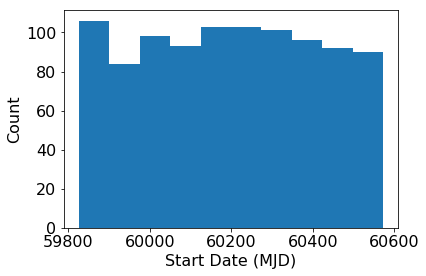

In [132]:
plt.hist(t_start)
plt.xlabel('Start Date (MJD)')
plt.ylabel('Count')

In the final catalog we produce we only want to include the systems we were able to match to a `gcr` galaxy.

In [144]:
results_dict = {}
print(len(keep_rows), len(gcr_z), len(t_start))
for keep_idx in range(len(keep_rows)):
    results_dict[str(unique_df['twinkles_sysno'].iloc[keep_rows[keep_idx]])] = {'z':gcr_z[keep_idx],
                                                                                'r_eff':gcr_r_eff[keep_idx],
                                                                                'sed_name':sed_name_array[keep_idx],
                                                                                'magNorm':magNorm_array[keep_idx],
                                                                                't_start':t_start[keep_idx]}

966 966 966


In [145]:
keep_systems = unique_df['twinkles_sysno'].iloc[keep_rows].values

In [150]:
final_df_z = []
final_df_r_eff = []
final_df_lens_sed = []
final_df_magNorm = []
final_df_t_start = []

keep_in_df = []

for idx, twinkles_sys in enumerate(df['twinkles_sysno']):
    if twinkles_sys in keep_systems:
        keep_in_df.append(idx)
        final_df_z.append(results_dict[str(twinkles_sys)]['z'])
        final_df_r_eff.append(results_dict[str(twinkles_sys)]['r_eff'])
        final_df_lens_sed.append(results_dict[str(twinkles_sys)]['sed_name'][0])
        final_df_magNorm.append(results_dict[str(twinkles_sys)]['magNorm'][0])
        final_df_t_start.append(results_dict[str(twinkles_sys)]['t_start'] + df.iloc[idx]['t0']) # Include time delay for each image

In [151]:
final_df = df.iloc[keep_in_df]
final_df = final_df.reset_index(drop=True)

In [152]:
final_df['bulge_magnorm'] = final_df_magNorm
final_df['r_eff'] = final_df_r_eff
final_df['lens_sed'] = final_df_lens_sed
final_df['t_start'] = final_df_t_start

In [159]:
final_df['twinkles_sysno'] += 1000 # The Final AGN systems are numbered up to 1000

In [160]:
final_df.head()

,t0,x,y,sigma,gamma,e,theta_e,theta_gamma,zs,zl,...,mag,mb,x0,x1,c,twinkles_sysno,bulge_magnorm,r_eff,lens_sed,t_start
0,0.000,0.2675,-0.4957,171.981337,0.073829,0.316210,79.160203,134.088420,0.734945,0.399013,...,22.807219,23.653111,0.000006,0.0,0.0,1000,20.670632,1.277249,galaxySED/Inst.50E09.1Z.spec.gz,60352.338088
1,14.945,-0.1250,0.1134,171.981337,0.073829,0.316210,79.160203,134.088420,0.734945,0.399013,...,23.665449,23.653111,0.000006,0.0,0.0,1000,20.670632,1.277249,galaxySED/Inst.50E09.1Z.spec.gz,60367.283088
2,0.000,-0.2566,-0.4932,165.882505,0.060948,0.556837,223.996858,85.495195,0.570129,0.304755,...,22.111893,22.681095,0.000015,0.0,0.0,1001,19.402538,0.298540,galaxySED/Exp.50E09.1Z.spec.gz,60388.511317
3,11.046,-0.0276,0.1673,165.882505,0.060948,0.556837,223.996858,85.495195,0.570129,0.304755,...,22.522105,22.681095,0.000015,0.0,0.0,1001,19.402538,0.298540,galaxySED/Exp.50E09.1Z.spec.gz,60399.557317
4,0.000,0.3682,0.4532,225.894439,0.064366,0.407094,260.542328,31.715262,0.826763,0.571931,...,23.299401,24.103708,0.000004,0.0,0.0,1002,20.061529,0.600005,galaxySED/Exp.50E09.04Z.spec.gz,59983.159556


Great! Looks like everything is in our new catalog and we can now save it to file.

In [161]:
final_df.to_csv('../../data/cosmoDC2_v1.1.4_sne_cat.csv', index=False)